## Using Monte Carlo Control

### Part 1: Implementation of Easy21

State s is the tuple (top, sum), action a is 0 for hit and 1 for stick. 

In [13]:
import random, numpy as np

In [14]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [15]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1]< 1 : # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, -1
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Step 2: Monte Carlo Control Implementation

In [16]:
# Initialize the value function, count of states, epsilon, N_0, and alpha.
N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
V = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
N0 = 100

number_of_episodes = 1000000

for episode in range(number_of_episodes):
    player_value = random.randint(1, 10)
    dealer_value = random.randint(1, 10)
    s = (dealer_value, player_value)
    a = 0 if random.random() < 0.5 else 1 # choose first action randomly

    while True:
        s_new, r = step(s, a)
        if s_new[1] >= 1 and s_new[1] <= 21:
            N[s_new[0], s_new[1], a] += 1
            alpha_t = 1 / N[s_new[0], s_new[1], a]
            V[s_new[0], s_new[1], a] += alpha_t * (r + np.max(V[s_new[0], :, :]) - V[s_new[0], s_new[1], a]) # update value function (max expected reward - curent value) -> Exery visit Monte Carlo

        if r != 0:
            break

        s = s_new
        epsilon_t = N0 / (N0 + N[s[0], s[1], a])
        a = np.argmax(V[s[0], s[1], :]) if random.random() > epsilon_t else random.randint(0, 1) # choose next action using epsilon-greedy policy


In [17]:
print("Value function for Easy21:"
      "\nHit Action:\n", V[:, :, 0],
      "\nStick Action:\n", V[:, :, 1])

Value function for Easy21:
Hit Action:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         11.4105506  11.41019014 11.39390661 11.40908411 11.41945447
  11.4101725  11.41586801 11.41654402 11.40331153 11.40020942 11.40985845
  11.42933316 11.42294696 11.42732136 11.40632109 11.42685413 11.41425219
  11.43291098 11.45329441 11.43501762 11.33216874]
 [ 0.         13.17957526 13.14951674 13.15888743 13.16672491 13.18511431
  13.20613726 13.20281503 13.16661141 13.18426286 13.18230964 13.17684088
  13.17366693 13.17059757 13.1656376  13.17806349 13.17303196 13.1947324
  13.19399394 13.2204481  13.21839025 13.11449307]
 [ 0.         13.87541999 13.91932104 13.8972764  13.93422903 13.90966698
  13.92929063 13.89100541 13.93223317 13.90062971 13.90327617 13.89461093
  13.91634209 13.9

In [18]:
Z_0 = np.transpose(V[:, :, 0])
Z_1 = np.transpose(V[:, :, 1])
Z = np.maximum(Z_0, Z_1)
Z_diff = Z_1 - Z_0
optimal_policy = np.argmax(V, axis=2)

In [19]:
print("\nOptimal Value Function:\n", Z)
print("\nOptimal Policy (0: Hit, 1: Stick):\n", optimal_policy)


Optimal Value Function:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         11.4105506  13.17957526 13.87541999 11.74967006 12.39750315
  13.87346496 13.56043797 11.5321533  11.63974461 15.55656753]
 [ 0.         11.41019014 13.14951674 13.91932104 11.79595614 12.37095353
  13.87809116 13.53784012 11.53985868 11.6720547  15.58287678]
 [ 0.         11.39390661 13.15888743 13.8972764  11.78744961 12.3800454
  13.89721264 13.57179741 11.54547381 11.67608603 15.5519015 ]
 [ 0.         11.40908411 13.16672491 13.93422903 11.79917201 12.40586583
  13.90490633 13.54231247 11.54107007 11.65459655 15.59769101]
 [ 0.         11.41945447 13.18511431 13.90966698 11.78437114 12.37934924
  13.89989143 13.55919243 11.52101323 11.68785171 15.55334772]
 [ 0.         11.4101725  13.20613726 13.92929063 11.78329699 12.39596268
  13.89797574 13.56903999 11.5319922  11.66982136 15.56972526]
 [ 0.         11.4158680

### Plotting the value function

In [20]:
import matplotlib.pyplot as plt

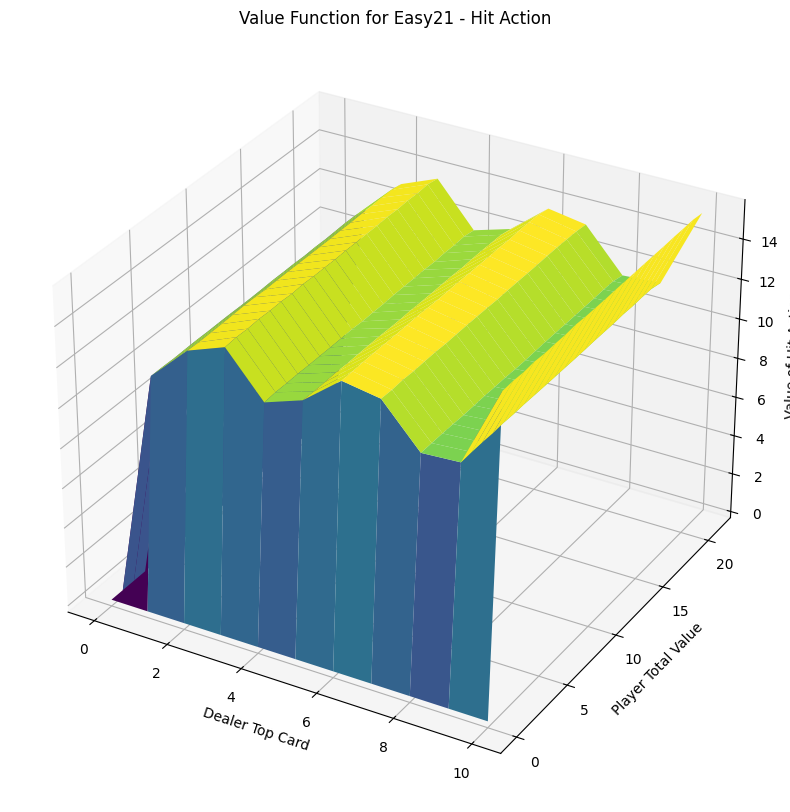

In [21]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
ax.plot_surface(X, Y, Z_0, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Hit Action')
plt.show()

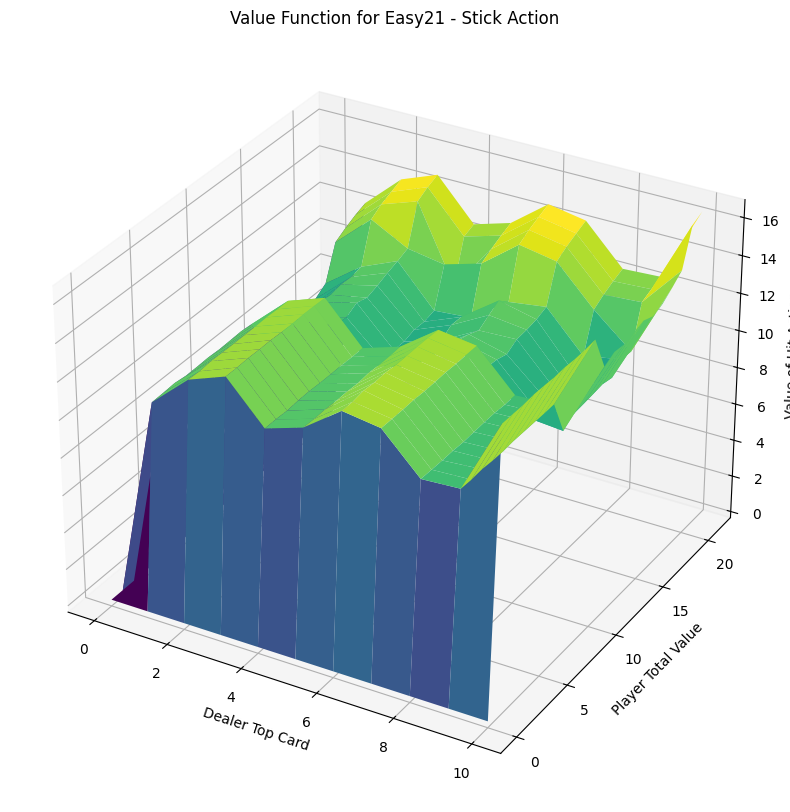

In [22]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_1, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Hit Action')
ax.set_title('Value Function for Easy21 - Stick Action')
plt.show()

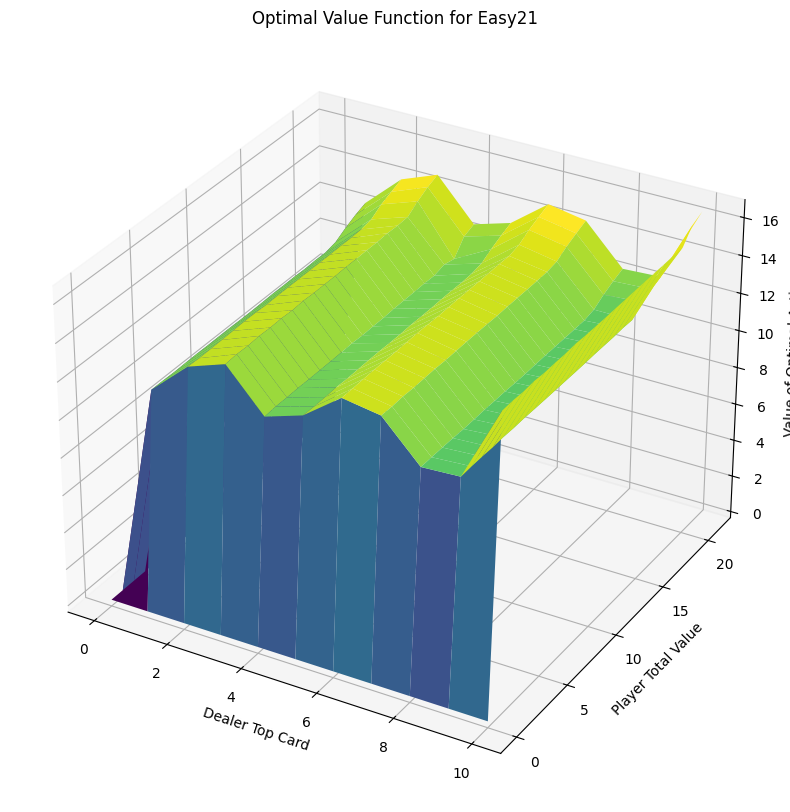

In [23]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Value of Optimal Action')
ax.set_title('Optimal Value Function for Easy21')
plt.show()

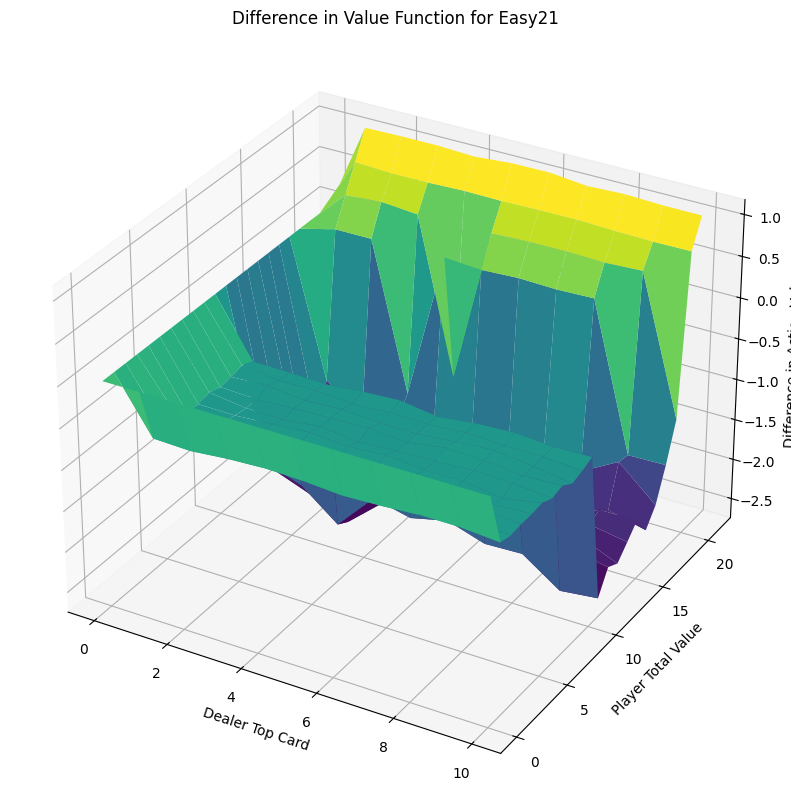

In [24]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_diff, cmap='viridis')
ax.set_xlabel('Dealer Top Card')
ax.set_ylabel('Player Total Value')
ax.set_zlabel('Difference in Action Values')
ax.set_title('Difference in Value Function for Easy21')
plt.show()

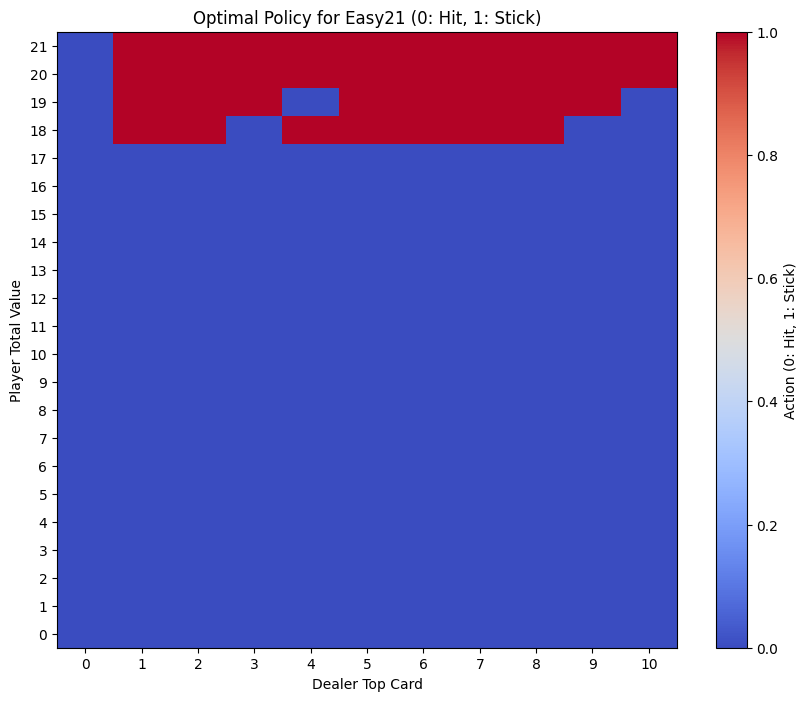

In [25]:
plt.figure(figsize=(10, 8))
plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Action (0: Hit, 1: Stick)')
plt.xlabel('Dealer Top Card')
plt.ylabel('Player Total Value')
plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
plt.show()